**EE-411 Homework 3 : Neural Networks**

*Name : Palmisano*

*First Name : Fabio Nicola Edouard*

*Sciper = 296708*


## **Part 1 : Backpropagation with logistic loss**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 30 17:17:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)

## 1.1) Function Predict:

In [4]:
# X : Array of shape B X D, W = {w_1 : D x K, w_2 : K x 1}

#Directly taken from the TP9

def np_sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def predict(X,W) :
    x_0 = X
    z_1 = np.dot(X,W["w_1"])
    X_1 = np_sigmoid(z_1)
    z_2 = np.dot(X_1,W["w_2"])
    y_hat = np_sigmoid(z_2)
    return (z_1, z_2, y_hat)




In [5]:
D = 7
K = 5
B = 100

X = np.random.rand(B, D)
W = {"w_1": np.random.rand(D, K), "w_2": np.random.rand(K, 1)}

z_1, z_2, y_hat = predict(X, W)
print(z_1.shape)
print(z_2.shape)
print(y_hat.shape)


(100, 5)
(100, 1)
(100, 1)


## 1.2) Function Logistic Loss:

In [6]:
import numpy as np

def logistic_loss(y, y_hat):
    """Compute the average logistic loss of a batch."""
    avg_log_loss = np.mean(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
    return avg_log_loss

In [7]:
y_hat = np.zeros((B, 1))
y = np.zeros((B, 1))
loss = logistic_loss(y, y_hat)
print(f"loss = {loss}")

loss = nan


It equal to zero because we can't calcul the logarithm of zero so that give us the Nan result.

## 1.3) Function  stable logistic loss:

So we start form the equation of the loss :
$\begin{equation}
\mathcal{L} (y, \hat{y}) = -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y}) \ \ \ with \ \ \ \hat{y} = \frac{1}{1+e^{-z_2}}
\end{equation}$
The we replace $\hat{y}$ in this equation by his value and we obtain
$\begin{equation}
y \log(1+e^{-z_2}) - (1 - y) \log(1 - \frac{1}{1+e^{-z_2}}) = y \log(1+e^{-z_2}) - (1 - y) \log(\frac{e^{-z_2}}{1+e^{-z_2}}) =  y \log(1+e^{-z_2}) + (1 - y)*z_2 + (1-y)\log(1+e^{-z_2})
\end{equation}$
Looking at the Documentation we know that $ logaddexp (a,b)= \log(e^{a} + e^{b})$ we have :
$\begin{equation}
\log(1+e^{-z_2}) + (1 - y)*z_2  = logaddexp(0,-z_2) + (1-y)*z_2
\end{equation}$

In [8]:
import numpy as np

def stable_logistic_loss(y, z2):
    """Compute the average stable logistic loss of a batch."""
    avg_loss = np.mean(np.logaddexp(0, -z2) + (1-y) * z2)
    return avg_loss

z2 = -10e10 * np.ones(B)
y = np.zeros((B, 1))
stable_loss = stable_logistic_loss(y, z2)
print(f"stable_loss = {stable_loss:.3f}")

stable_loss = 0.000


So we have a stable implementation of our logistic loss.

## 1.4) Derive Analytically (Notebook)

$\begin{equation}
\dfrac{\partial \mathcal{L}}{\partial w^{(1)}_{i,j}}=\dfrac{\partial \mathcal{L}}{\partial z^{(2)}_{i}} \cdot \dfrac{\partial z^{(2)}_{i}}{\partial z^{(1)}_{i}} \cdot \dfrac{\partial z^{(1)}_{i}}{\partial w^{(1)}_{i,j}} \ \ \ and \ \ \          \dfrac{\partial \mathcal{L}}{\partial w^{(2)}_{i}}=\dfrac{\partial \mathcal{L}}{\partial z^{(1)}_{i}} \cdot \dfrac{\partial z^{(2)}_{i}}{\partial w^{(2)}_{i}}
\end{equation}$
Developping what we obtain above we add :
$\begin{equation}
\dfrac{\partial \mathcal{L}}{\partial z^{(2)}_{i}} = (1 - y) - \frac{e^{-z_i^{2}}}{1+e^{-z_i^{2}}} = (1-y) - ( 1 - \sigma(z_i^{2})) = (1-y) - ( 1 - \hat{y}) =  \hat{y} - y
\end{equation}$

$\begin{equation}
\dfrac{\partial z^{(2)}_{i}}{\partial z^{(1)}_{i}} = \dfrac{\partial(w^{(2)} x^{(1)})}{\partial z^{(1)}_{i}} = w^{(2)} \sigma(z_i^{(1)}) (1 - \sigma(z_i^{(1)}))
\end{equation}$


$\begin{equation}
\dfrac{\partial z^{(1)}_{i}}{\partial w^{(1)}_{i,j}} = x^{(0)} \ \ \ and \ \ \ \dfrac{\partial z^{(2)}_{i}}{\partial w^{(2)}_{i}} = x^{(1)} = \sigma(z_i^{(1)})
\end{equation}$

And we finally obtain this result :

$\begin{equation}
\dfrac{\partial \mathcal{L}}{\partial w^{(1)}_{i,j}} = (\hat{y} - y) \cdot w^{(2)} \cdot \sigma(z_i^{(1)}) (1 - \sigma(z_i^{(1)})) \cdot  x^{(0)}  \ \ \ and \ \ \ \dfrac{\partial \mathcal{L}}{\partial w^{(2)}_{i}}= (\hat{y} - y)\cdot \sigma(z_i^{(1)})
\end{equation}$


## 1.5) Implement Gradient

In [9]:
def gradient(X, y, W):
    """Compute the gradient of the average loss with respect to all the weights."""
    z_1, z_2, y_hat = predict(X, W)
    print(y_hat.shape)
    print(z_1.shape)
    print(z_2.shape)
    dLdz2 = y_hat - y
    dLdw2 = np.dot(np_sigmoid(z_1).T, dLdz2)
    dz2dz1 = W["w_2"].T * np_sigmoid(z_1) * (1 - np_sigmoid(z_1))
    dLdw1 = np.dot(X.T, dLdz2 * dz2dz1)
    return (dLdw1, dLdw2)


In [10]:
D = 7
K = 5
B = 100

X = np.random.rand(B, D)-0.5
W = {
    "w_1": np.random.rand(D, K)-0.5,
    "w_2": np.random.rand(K, 1)-0.5
}

g_w1, g_w2 = gradient(X, y, W)
print(g_w1.shape)
print(g_w2.shape)


(100, 1)
(100, 5)
(100, 1)
(7, 5)
(5, 1)


## **Part 2 : Classifying KMNIST using neural networks**

In [11]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [12]:
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01
EPOCHS = 20


In [13]:
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [14]:
transform = T.Compose([T.ToTensor()])

# load the train dataset
train_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

# Create the validation dataset from the train dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

100%|██████████| 18165135/18165135 [00:25<00:00, 713601.59it/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 377522.43it/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:01<00:00, 2992583.18it/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 7013336.54it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [15]:
# construct the dataloader for the traininig dataset.
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)


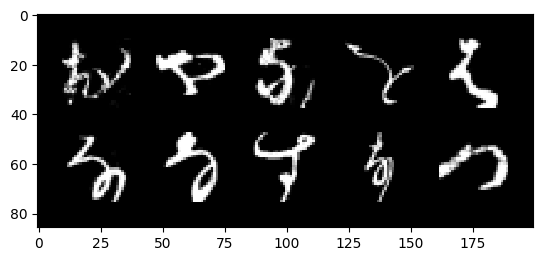

In [16]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

### ANSWER THE Q

## 2.2) MLP

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        output = self.fc3(x)
        return output


In [18]:
accuracies = []
models = []
losses = []
def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''
    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()


        # perform the gradient step
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader.dataset)


from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

def predict(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )
        accuracies.append(accuracy)
    return test_loss, accuracy

def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)


def plot_loss(losses, ylim=None):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(ylim)
    plt.title("Loss progression across epochs")

SGD with LR = 0.01
Epoch 0: Train Loss=0.0023, Validation Loss=2.2952, Validation acc=14.3600
Epoch 1: Train Loss=0.0022, Validation Loss=2.2838, Validation acc=20.1900
Epoch 2: Train Loss=0.0022, Validation Loss=2.2699, Validation acc=25.9900
Epoch 3: Train Loss=0.0022, Validation Loss=2.2515, Validation acc=30.0800
Epoch 4: Train Loss=0.0022, Validation Loss=2.2269, Validation acc=36.8200
Epoch 5: Train Loss=0.0022, Validation Loss=2.1936, Validation acc=44.2100
Epoch 6: Train Loss=0.0021, Validation Loss=2.1487, Validation acc=47.7200
Epoch 7: Train Loss=0.0021, Validation Loss=2.0901, Validation acc=48.9000
Epoch 8: Train Loss=0.0020, Validation Loss=2.0178, Validation acc=50.1700
Epoch 9: Train Loss=0.0019, Validation Loss=1.9352, Validation acc=52.2700
Epoch 10: Train Loss=0.0019, Validation Loss=1.8488, Validation acc=54.1800
Epoch 11: Train Loss=0.0018, Validation Loss=1.7638, Validation acc=56.2700
Epoch 12: Train Loss=0.0017, Validation Loss=1.6809, Validation acc=58.9300
Epo

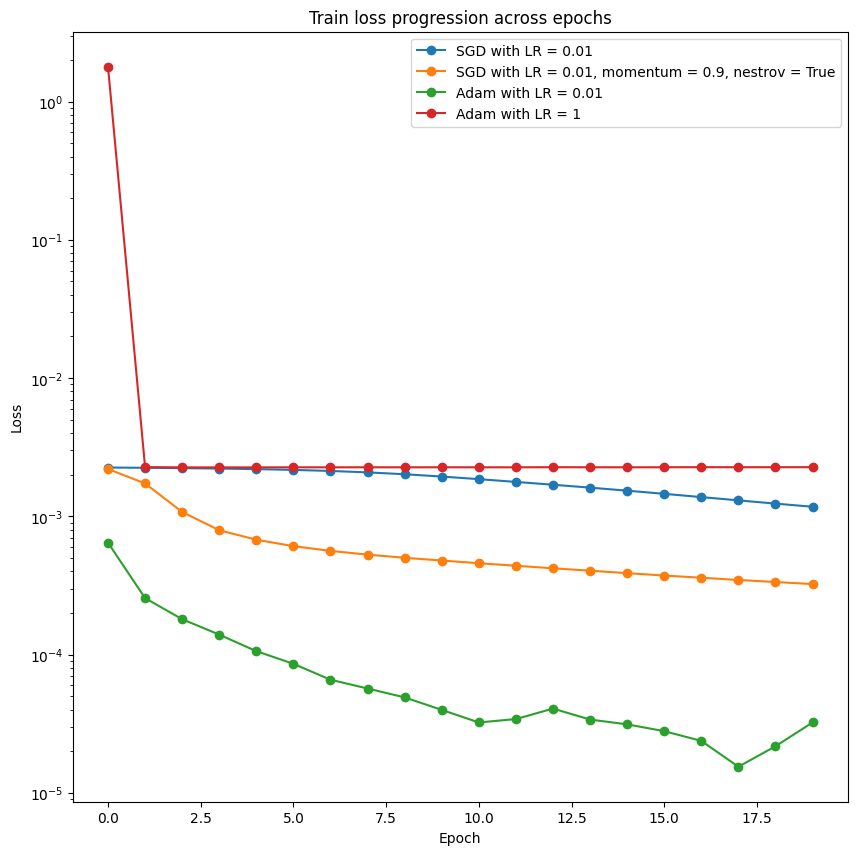

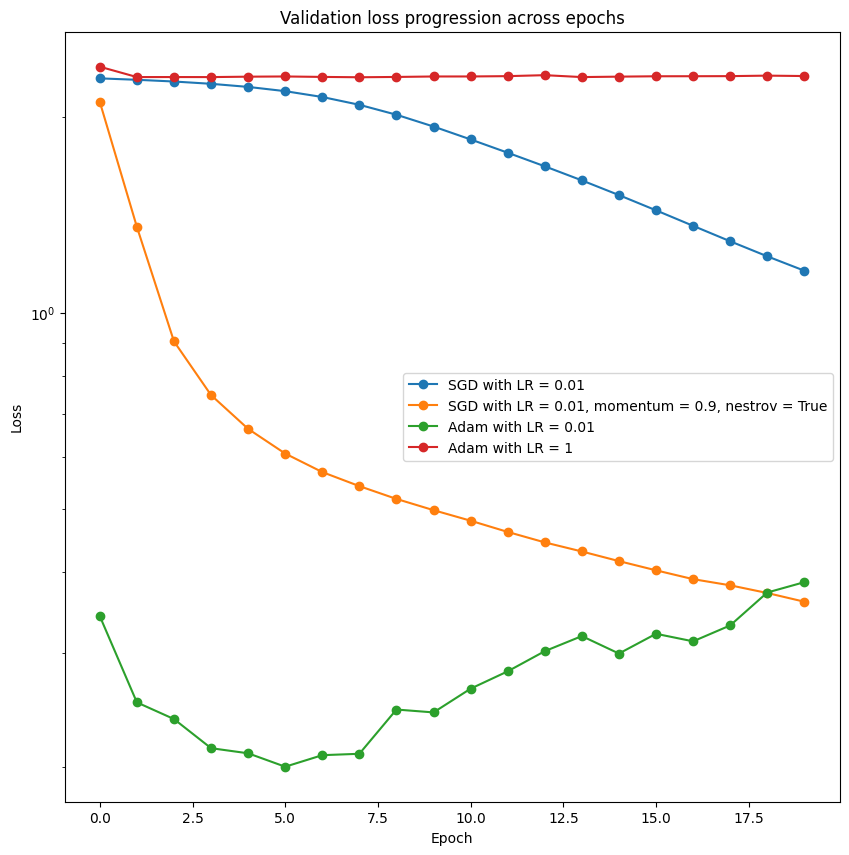

In [19]:

#Model with Optimizer : SGD and Learning Rate : 0.01
modelSGD_001 = MLP()
optimizerSGD_001 = optim.SGD(modelSGD_001.parameters(), lr=0.01)
models.append('SGD with LR = 0.01')
print('SGD with LR = 0.01')
train_lossesSGD_001, valid_lossesSGD_001, valid_accsSGD_001 = fit(modelSGD_001, train_dataloader,  optimizerSGD_001, EPOCHS, device = DEVICE,valid_dataloader= validation_dataloader)
predict(modelSGD_001, test_dataloader, device = DEVICE)


#Model with Optimizer : SGD with momentum and Learning Rate : 0.01, momentum : 0.9, nestrov : True
modelSGD_001_momentum = MLP()
optimizerSGD_001_momentum = optim.SGD(modelSGD_001_momentum.parameters(), lr=0.01, momentum=0.9, nesterov=True)
models.append('SGD with Momentum')
print('SGD with LR = 0.01, momentum = 0.9, nestrov = True')
train_lossesSGD_001_momentum, valid_lossesSGD_001_momentum, valid_accsSGD_001_momentum = fit(modelSGD_001_momentum, train_dataloader, optimizerSGD_001_momentum, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelSGD_001_momentum, test_dataloader, device = DEVICE)


#Model with Adam Optimizer and Learning Rate : 0.01
modelAdam_001 = MLP()
optimizerAdam_001 = optim.Adam(modelAdam_001.parameters(), lr=0.01)
models.append('Adam with LR = 0.01')
print('Adam with LR = 0.01')
train_lossesAdam_001, valid_lossesAdam_001, valid_accsAdam_001 = fit(modelAdam_001, train_dataloader, optimizerAdam_001, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelAdam_001, test_dataloader, device = DEVICE)

#Model with Adam Optimizer and Learning Rate : 1
modelAdam_1 = MLP()
optimizerAdam_1 = optim.Adam(modelAdam_1.parameters(), lr=1)
models.append('Adam with LR = 1')
print('Adam with LR = 1')
train_lossesAdam_1, valid_lossesAdam_1, valid_accsAdam_1 = fit(modelAdam_1, train_dataloader, optimizerAdam_1, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelAdam_1, test_dataloader, device = DEVICE)


plt.figure(figsize=(10, 10))
plt.plot(train_lossesSGD_001, label = "SGD with LR = 0.01", marker = 'o')
plt.plot(train_lossesSGD_001_momentum, label = "SGD with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.plot(train_lossesAdam_001, label = "Adam with LR = 0.01", marker = 'o')
plt.plot(train_lossesAdam_1,  label = "Adam with LR = 1", marker = 'o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Train loss progression across epochs")
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(valid_lossesSGD_001, label = "SGD with LR = 0.01", marker = 'o')
plt.plot(valid_lossesSGD_001_momentum, label = "SGD with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.plot(valid_lossesAdam_001, label = "Adam with LR = 0.01", marker = 'o')
plt.plot(valid_lossesAdam_1,  label = "Adam with LR = 1", marker = 'o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Validation loss progression across epochs")
plt.show()

In [20]:
print('Validation Accuracy with SGD with LR = 0.01')
loss_SGD001, accuracy_SGD001 = predict(modelSGD_001, test_dataloader, device = DEVICE)
models.append('modelSGD_001')
losses.append(loss_SGD001)
print('----------------------------------------------------------------------')
print('Validation Accuracy with SGD with LR = 0.01, momentum = 0.9, nestrov = True')
loss_SGDMom,accuracy_SGDMom =predict(modelSGD_001_momentum, test_dataloader, device = DEVICE)
models.append('modelSGD_001_momentum')
losses.append(loss_SGDMom)
print('----------------------------------------------------------------------')
print('Validation Accuracy with Adam with LR = 0.01')
loss_Adam001, accuracy_Adam001 = predict(modelAdam_001, test_dataloader, device = DEVICE)
models.append('modelAdam_001')
losses.append(loss_Adam001)
print('----------------------------------------------------------------------')
print('Validation Accuracy with Adam with LR = 1')
loss_Adam1, accuracy_Adam1 = predict(modelAdam_1, test_dataloader, device = DEVICE)
models.append('modelAdam_1')
losses.append(loss_Adam1)


Validation Accuracy with SGD with LR = 0.01
Test set: Avg. loss: 1.5763, Accuracy: 5346/10000 (53%)
----------------------------------------------------------------------
Validation Accuracy with SGD with LR = 0.01, momentum = 0.9, nestrov = True
Test set: Avg. loss: 0.6934, Accuracy: 7863/10000 (79%)
----------------------------------------------------------------------
Validation Accuracy with Adam with LR = 0.01
Test set: Avg. loss: 0.9625, Accuracy: 8742/10000 (87%)
----------------------------------------------------------------------
Validation Accuracy with Adam with LR = 1
Test set: Avg. loss: 4.4112, Accuracy: 1000/10000 (10%)


We can directly see that the model with SGD with momentum is better than the model with simple SGD. But the overall best model is with the optimizer Adam with a learning rate not so high. Indeed we see that with a too higher Learning Rate we obtain a really bad result. So here with learning rate of 0.01 and Adam we obtain an accuracy of about 89% (See DataFrame Summary below).

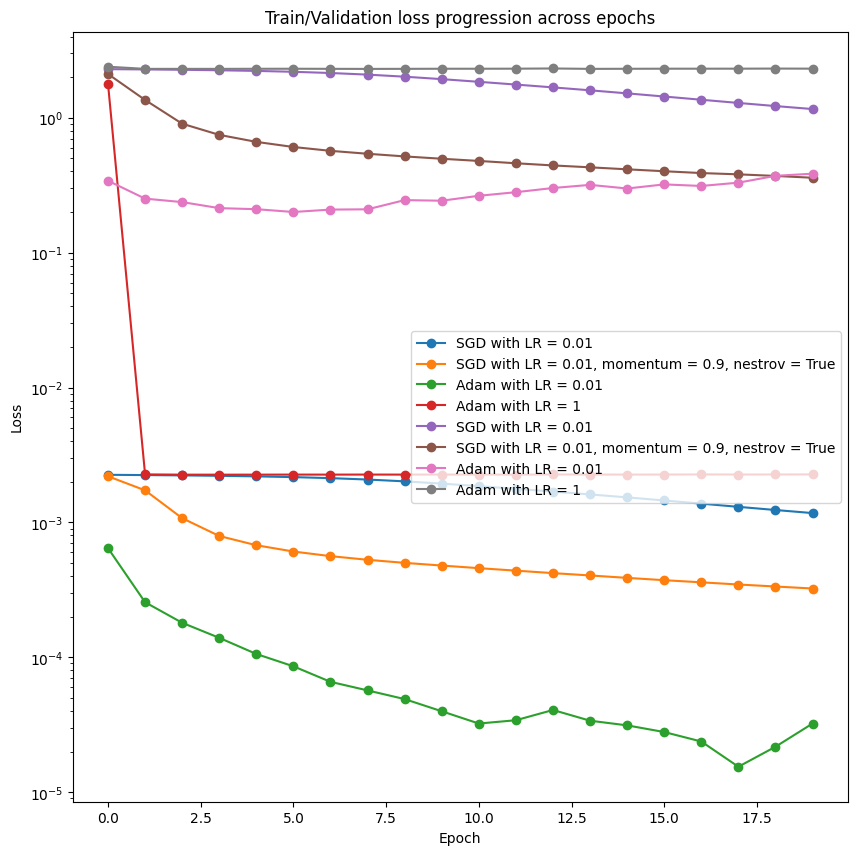

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(train_lossesSGD_001, label = "SGD with LR = 0.01", marker = 'o')
plt.plot(train_lossesSGD_001_momentum, label = "SGD with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.plot(train_lossesAdam_001, label = "Adam with LR = 0.01", marker = 'o')
plt.plot(train_lossesAdam_1,  label = "Adam with LR = 1", marker = 'o')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Train/Validation loss progression across epochs")
plt.plot(valid_lossesSGD_001, label = "SGD with LR = 0.01", marker = 'o')
plt.plot(valid_lossesSGD_001_momentum, label = "SGD with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.plot(valid_lossesAdam_001, label = "Adam with LR = 0.01", marker = 'o')
plt.plot(valid_lossesAdam_1,  label = "Adam with LR = 1", marker = 'o')
plt.legend(loc ='center right')
plt.show()

## 2.3) Same but with CNN

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


SGD in CNN with LR = 0.01
Epoch 0: Train Loss=0.0023, Validation Loss=2.3056, Validation acc=10.2900
Epoch 1: Train Loss=0.0023, Validation Loss=2.3021, Validation acc=11.0500
Epoch 2: Train Loss=0.0023, Validation Loss=2.2993, Validation acc=11.5400
Epoch 3: Train Loss=0.0023, Validation Loss=2.2967, Validation acc=11.9800
Epoch 4: Train Loss=0.0022, Validation Loss=2.2938, Validation acc=13.1300
Epoch 5: Train Loss=0.0022, Validation Loss=2.2905, Validation acc=15.4300
Epoch 6: Train Loss=0.0022, Validation Loss=2.2867, Validation acc=18.5600
Epoch 7: Train Loss=0.0022, Validation Loss=2.2819, Validation acc=20.2000
Epoch 8: Train Loss=0.0022, Validation Loss=2.2759, Validation acc=21.6200
Epoch 9: Train Loss=0.0022, Validation Loss=2.2682, Validation acc=23.3300
Epoch 10: Train Loss=0.0022, Validation Loss=2.2579, Validation acc=26.7000
Epoch 11: Train Loss=0.0022, Validation Loss=2.2437, Validation acc=30.4200
Epoch 12: Train Loss=0.0022, Validation Loss=2.2234, Validation acc=32.4

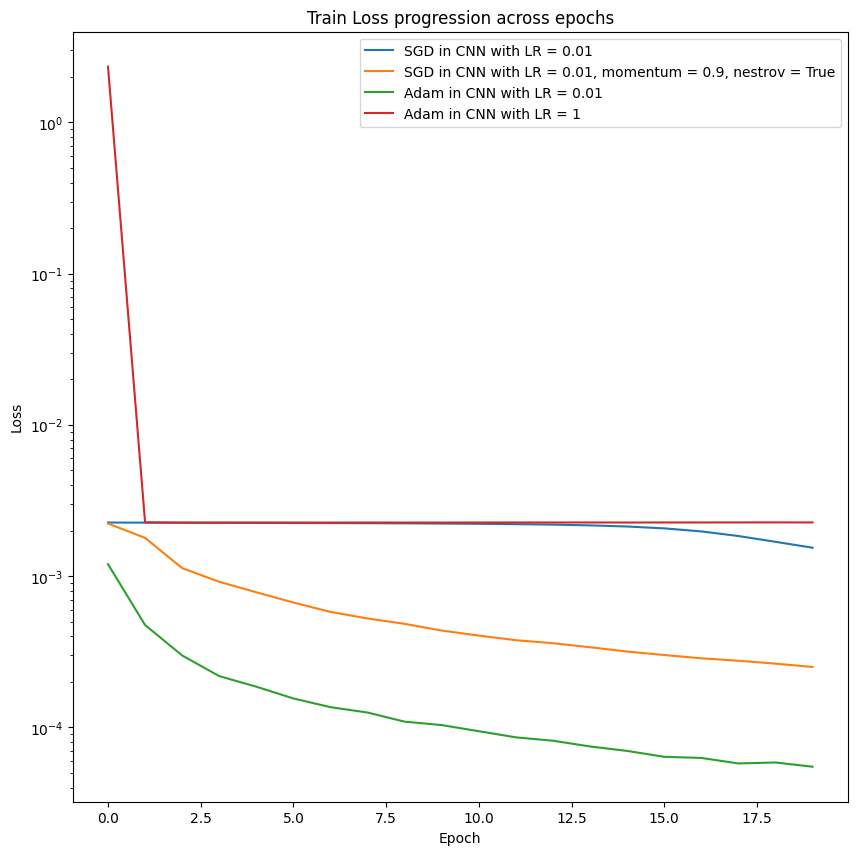

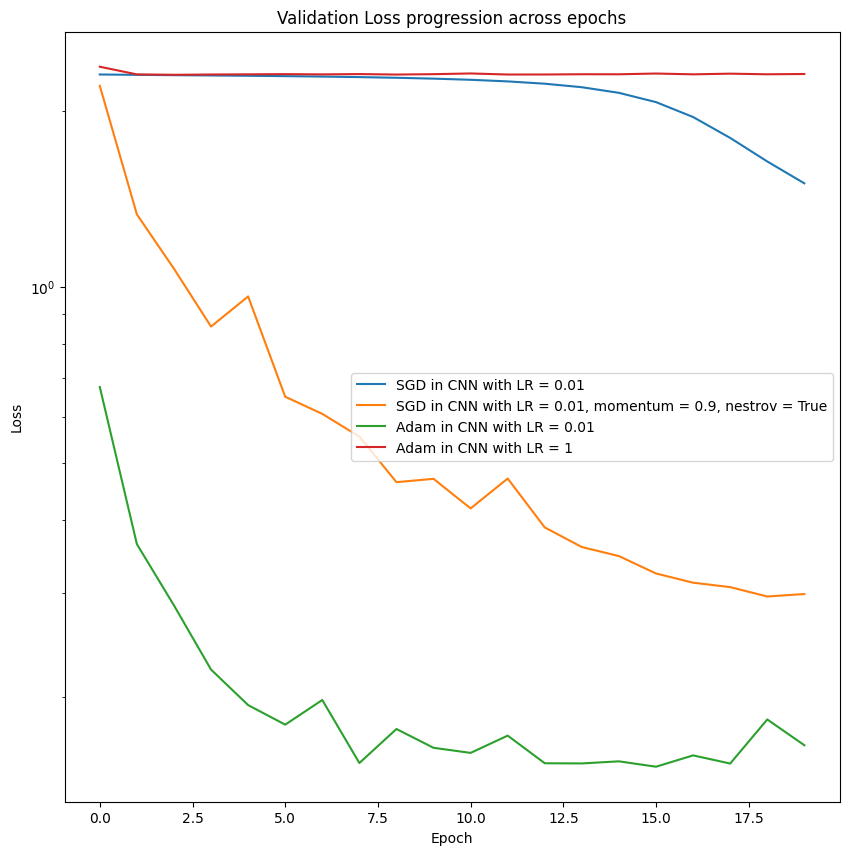

In [23]:
#Model with Optimizer : SGD and Learning Rate : 0.01
modelSGD_001_CNN = CNN()
optimizerSGD_001_CNN = optim.SGD(modelSGD_001_CNN.parameters(), lr=0.01)
print('SGD in CNN with LR = 0.01')
train_lossesSGD_001_CNN, valid_lossesSGD_001_CNN, valid_accsSGD_001_CNN = fit(modelSGD_001_CNN, train_dataloader, optimizerSGD_001_CNN, EPOCHS, device = DEVICE, valid_dataloader=validation_dataloader)
predict(modelSGD_001_CNN, test_dataloader, device = DEVICE)


#Model with Optimizer : SGD with momentum and Learning Rate : 0.01, momentum : 0.9, nestrov : True
modelSGD_001_momentum_CNN = CNN()
optimizerSGD_001_momentum_CNN = optim.SGD(modelSGD_001_momentum_CNN.parameters(), lr=0.01, momentum=0.9, nesterov=True)
print('SGD in CNN with LR = 0.01, momentum = 0.9, nestrov = True')
train_lossesSGD_001_momentum_CNN, valid_lossesSGD_001_momentum_CNN, valid_accsSGD_001_momentum_CNN = fit(modelSGD_001_momentum_CNN, train_dataloader, optimizerSGD_001_momentum_CNN, EPOCHS, device = DEVICE, valid_dataloader=validation_dataloader)
predict(modelSGD_001_momentum_CNN, test_dataloader, device = DEVICE)


#Model with Adam Optimizer and Learning Rate : 0.01
modelAdam_001_CNN = CNN()
optimizerAdam_001_CNN = optim.Adam(modelAdam_001_CNN.parameters(), lr=0.01)
print('Adam in CNN with LR = 0.01')
train_losses_adam001_CNN, valid_losses_adam001_CNN, valid_accs_adam001_CNN = fit(modelAdam_001_CNN, train_dataloader, optimizerAdam_001_CNN, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelAdam_001_CNN, test_dataloader, device = DEVICE)


#Model with Adam Optimizer and Learning Rate : 1
modelAdam_1_CNN = CNN()
optimizerAdam_1_CNN = optim.Adam(modelAdam_1_CNN.parameters(), lr=1)
print('Adam in CNN with LR = 1')
train_lossesAdam_1_CNN, valid_lossesAdam_1_CNN, valid_accsAdam_1_CNN = fit(modelAdam_1_CNN, train_dataloader, optimizerAdam_1_CNN, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelAdam_1_CNN, test_dataloader, device = DEVICE)




plt.figure(figsize=(10, 10))
plt.plot(train_lossesSGD_001_CNN, label = "SGD in CNN with LR = 0.01")
plt.plot(train_lossesSGD_001_momentum_CNN, label = "SGD in CNN with LR = 0.01, momentum = 0.9, nestrov = True")
plt.plot(train_losses_adam001_CNN, label = "Adam in CNN with LR = 0.01")
plt.plot(train_lossesAdam_1_CNN,  label = "Adam in CNN with LR = 1")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Train Loss progression across epochs")
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Validation Loss progression across epochs")
plt.plot(valid_lossesSGD_001_CNN, label = "SGD in CNN with LR = 0.01")
plt.plot(valid_lossesSGD_001_momentum_CNN, label = "SGD in CNN with LR = 0.01, momentum = 0.9, nestrov = True")
plt.plot(valid_losses_adam001_CNN, label = "Adam in CNN with LR = 0.01")
plt.plot(valid_lossesAdam_1_CNN,  label = "Adam in CNN with LR = 1")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.show()


In [24]:
print('Validation Accuracy with SGD with LR = 0.01')
predict(modelSGD_001_CNN, test_dataloader, device = DEVICE)
models.append('modelSGD_001_CNN')
print('----------------------------------------------------------------------')
print('Validation Accuracy with SGD with LR = 0.01, momentum = 0.9, nestrov = True')
predict(modelSGD_001_momentum_CNN, test_dataloader, device = DEVICE)
models.append('modelSGD_001_momentum_CNN')
print('----------------------------------------------------------------------')
print('Validation Accuracy with Adam with LR = 0.01')
predict(modelAdam_001_CNN, test_dataloader, device = DEVICE)
models.append('modelAdam_001_CNN')
print('----------------------------------------------------------------------')
print('Validation Accuracy with Adam with LR = 1')
models.append('modelAdam_1_CNN')
predict(modelAdam_1_CNN, test_dataloader, device = DEVICE)

Validation Accuracy with SGD with LR = 0.01
Test set: Avg. loss: 1.7454, Accuracy: 3966/10000 (40%)
----------------------------------------------------------------------
Validation Accuracy with SGD with LR = 0.01, momentum = 0.9, nestrov = True
Test set: Avg. loss: 0.5717, Accuracy: 8295/10000 (83%)
----------------------------------------------------------------------
Validation Accuracy with Adam with LR = 0.01
Test set: Avg. loss: 0.4176, Accuracy: 9030/10000 (90%)
----------------------------------------------------------------------
Validation Accuracy with Adam with LR = 1
Test set: Avg. loss: 2.3097, Accuracy: 1000/10000 (10%)


(2.30974287109375, tensor(10., device='cuda:0'))

Here we obtain approximatively the same result as before, we can just say that we increase slightly our accuracy for SGD with momentum model. And the Adam with learning rate of 0.01 increase with CNN his performance and improve our predictions. And always with so big learning rate (= 1) Adam become a bad model. (See DataFrame summary below)

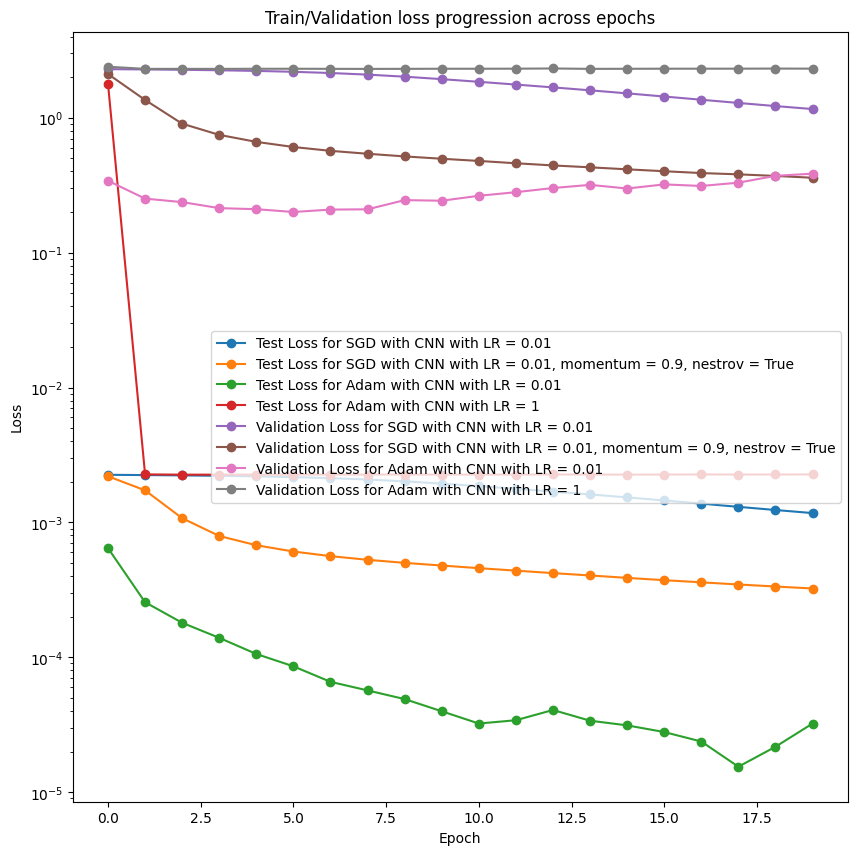

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(train_lossesSGD_001, label = "Test Loss for SGD with CNN with LR = 0.01", marker = 'o')
plt.plot(train_lossesSGD_001_momentum, label = "Test Loss for SGD with CNN with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.plot(train_lossesAdam_001, label = "Test Loss for Adam with CNN with LR = 0.01", marker = 'o')
plt.plot(train_lossesAdam_1,  label = "Test Loss for Adam with CNN with LR = 1", marker = 'o')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Train/Validation loss progression across epochs")
plt.plot(valid_lossesSGD_001, label = "Validation Loss for SGD with CNN with LR = 0.01", marker = 'o')
plt.plot(valid_lossesSGD_001_momentum, label = "Validation Loss for SGD with CNN with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.plot(valid_lossesAdam_001, label = "Validation Loss for Adam with CNN with LR = 0.01", marker = 'o')
plt.plot(valid_lossesAdam_1,  label = "Validation Loss for Adam with CNN with LR = 1", marker = 'o')
plt.legend(loc ='center right')
plt.show()

In [26]:
integer_values = [tensor.item() for tensor in accuracies]
models = ['SGD', 'SGD with Momentum', 'Adam', 'Adam', 'SGD', 'SGD with Momentum', 'Adam', 'Adam']
learning_rate = ['0.01', '0.01', '0.01', '1', '0.01', '0.01', '0.01', '1']
Neural_Net = ['MLP','MLP','MLP','MLP','CNN','CNN','CNN','CNN' ]
dataset = ['KMNIST', 'KMNIST', 'KMNIST', 'KMNIST', 'KMNIST', 'KMNIST', 'KMNIST', 'KMNIST']
integer_values = integer_values[:4] + integer_values[-4:]
df = pd.DataFrame({'Models': models, 'Learning Rate': learning_rate, 'Neural Net': Neural_Net ,'Dataset': dataset,'Accuracies': integer_values})
df['Accuracies'] = df['Accuracies'].apply(lambda x: np.round(x,2))
df

,Models,Learning Rate,Neural Net,Dataset,Accuracies
0,SGD,0.01,MLP,KMNIST,53.46
1,SGD with Momentum,0.01,MLP,KMNIST,78.63
2,Adam,0.01,MLP,KMNIST,87.42
3,Adam,1,MLP,KMNIST,10.00
4,SGD,0.01,CNN,KMNIST,39.66
5,SGD with Momentum,0.01,CNN,KMNIST,82.95
6,Adam,0.01,CNN,KMNIST,90.30
7,Adam,1,CNN,KMNIST,10.00


Here there is a small DataFrame that summaries the result that we obtain with MLP and CNN. And we can directly see that our best models are with ADAM Learnin rate of 0.01. But be carefull with Adam that the result can become really bad if we increase to much the learning rate. But we can conclude really succesfully that one of the two models is really better than the other.

## 2.4) Parameters

In [27]:
def compute_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
print(compute_number_parameters(MLP()))
print(compute_number_parameters(CNN()))

89610
23946


We see that the result are approximatively similar between our models. But the number of parameters needed for the computation of this model is much much higher in the MLP Neural Network. So having more parameters don't bring necessarily better results. And we know fro lecture, that having less parameter is better to a less energy consumption.

## 2.5) PermutedKMNIST

In [29]:
#Directly taken form the Homework Instruction Sheet
class RandomPermutation(object):
  def __init__(self, num_features):
    self.num_features = num_features
    self.reindex = torch.randperm(num_features)
  def __call__(self, img):
    assert self.num_features == img.numel()
    orig_shape = img.shape
    img = img.view(-1)[self.reindex].view(orig_shape)
    return img

In [30]:
transform_permuted = T.Compose([T.ToTensor(), RandomPermutation(28*28)])

# load the train dataset
train_permuted_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform_permuted)

# load the test dataset
test_permuted_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform_permuted)

# Create the validation dataset from the train dataset
train_permuted_dataset, val_permuted_dataset = torch.utils.data.random_split(train_permuted_dataset, [50000, 10000])

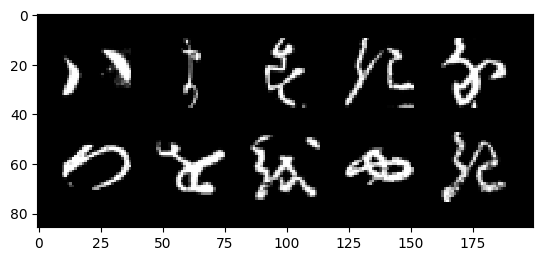

In [31]:
# construct the dataloader for the traininig dataset.
# Here we shuffle the data to promote stochasticity.
train_permuted_dataloader = torch.utils.data.DataLoader(
    dataset=train_permuted_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_permuted_dataloader = torch.utils.data.DataLoader(
    dataset=test_permuted_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

validation_permuted_dataloader = torch.utils.data.DataLoader(
    dataset=val_permuted_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

In [32]:
#Model with Optimizer : SGD with momentum and Learning Rate : 0.01, momentum : 0.9, nestrov : True
SGD_001_momentum_permuted = MLP()
optimizerSGD_001_momentum_permuted = optim.SGD(SGD_001_momentum_permuted.parameters(), lr=0.01, momentum=0.9, nesterov=True)
print('MLP of SGD of permuted Set with LR = 0.01, momentum = 0.9, nestrov = True')
train_lossesSGD_001_momentum_perm, valid_lossesSGD_001_momentum_perm, valid_accsSGD_001_momentum_perm = fit(SGD_001_momentum_permuted, train_permuted_dataloader, optimizerSGD_001_momentum_permuted, EPOCHS, device = DEVICE,valid_dataloader=validation_permuted_dataloader)
predict(SGD_001_momentum_permuted, test_permuted_dataloader, device = DEVICE)

#Model with Optimizer and CNN : SGD with momentum and Learning Rate : 0.01, momentum : 0.9, nestrov : True
SGD_001_momentum_permuted_CNN = CNN()
optimizerSGD_001_momentum_permuted_CNN = optim.SGD(SGD_001_momentum_permuted_CNN.parameters(), lr=0.01, momentum=0.9, nesterov=True)
print('CNN of SGD of permuted Set with LR = 0.01, momentum = 0.9, nestrov = True')
train_lossesSGD_001_momentum_perm_CNN, valid_lossesSGD_001_momentum_perm_CNN, valid_accsSGD_001_momentum_perm_CNN = fit(SGD_001_momentum_permuted_CNN, train_permuted_dataloader, optimizerSGD_001_momentum_permuted_CNN, EPOCHS, device = DEVICE,valid_dataloader=validation_permuted_dataloader)
predict(SGD_001_momentum_permuted_CNN, test_permuted_dataloader, device = DEVICE)



MLP of SGD of permuted Set with LR = 0.01, momentum = 0.9, nestrov = True
Epoch 0: Train Loss=0.0022, Validation Loss=2.1198, Validation acc=45.1400
Epoch 1: Train Loss=0.0017, Validation Loss=1.3940, Validation acc=65.3400
Epoch 2: Train Loss=0.0011, Validation Loss=0.9094, Validation acc=74.6500
Epoch 3: Train Loss=0.0008, Validation Loss=0.7341, Validation acc=78.3700
Epoch 4: Train Loss=0.0007, Validation Loss=0.6441, Validation acc=80.8300
Epoch 5: Train Loss=0.0006, Validation Loss=0.5902, Validation acc=82.2600
Epoch 6: Train Loss=0.0006, Validation Loss=0.5507, Validation acc=83.2200
Epoch 7: Train Loss=0.0005, Validation Loss=0.5208, Validation acc=84.3600
Epoch 8: Train Loss=0.0005, Validation Loss=0.4954, Validation acc=84.8800
Epoch 9: Train Loss=0.0005, Validation Loss=0.4753, Validation acc=85.6300
Epoch 10: Train Loss=0.0005, Validation Loss=0.4569, Validation acc=86.2000
Epoch 11: Train Loss=0.0004, Validation Loss=0.4393, Validation acc=86.6600
Epoch 12: Train Loss=0.0

(1.3787955810546875, tensor(56.2200, device='cuda:0'))

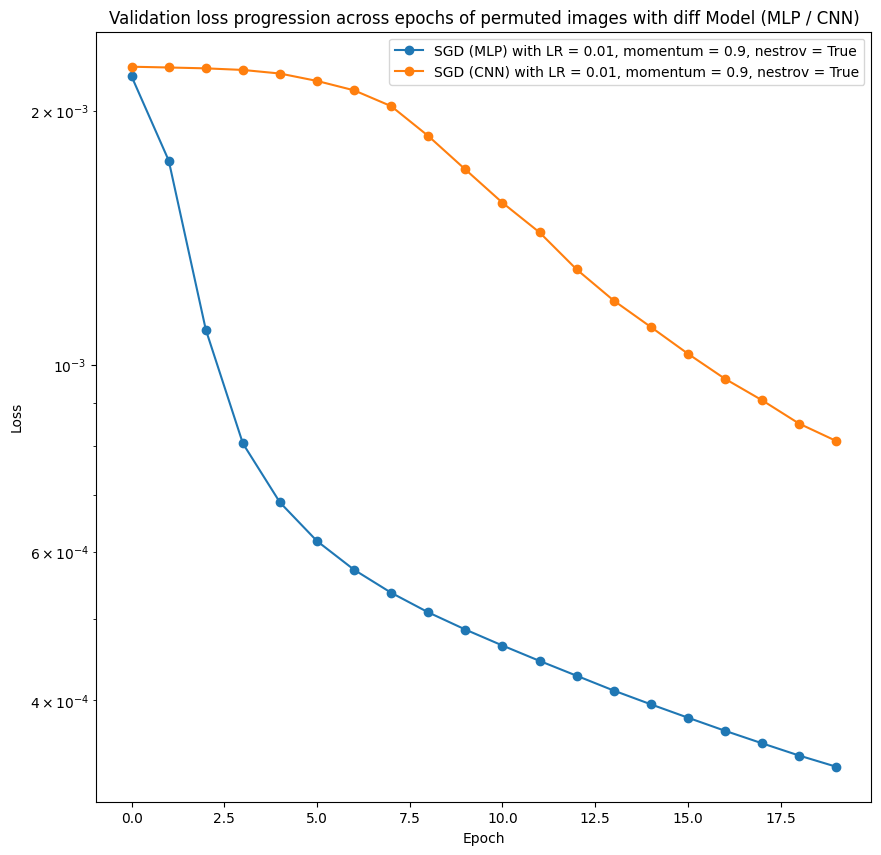

In [33]:
plt.figure(figsize=(10, 10))
plt.plot(train_lossesSGD_001_momentum_perm, label = "SGD (MLP) with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.plot(train_lossesSGD_001_momentum_perm_CNN, label = "SGD (CNN) with LR = 0.01, momentum = 0.9, nestrov = True", marker = 'o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Validation loss progression across epochs of permuted images with diff Model (MLP / CNN)")
plt.show()

In [34]:
print('Validation Accuracy model MLP with SGD with LR = 0.01, momentum = 0.9, nestrov = True')
predict(SGD_001_momentum_permuted, test_permuted_dataloader, device = DEVICE)
print('----------------------------------------------------------------------')
print('Validation Accuracy model CNN with SGD with LR = 0.01, momentum = 0.9, nestrov = True')
predict(SGD_001_momentum_permuted_CNN, test_permuted_dataloader, device = DEVICE)


Validation Accuracy model MLP with SGD with LR = 0.01, momentum = 0.9, nestrov = True
Test set: Avg. loss: 0.6906, Accuracy: 7841/10000 (78%)
----------------------------------------------------------------------
Validation Accuracy model CNN with SGD with LR = 0.01, momentum = 0.9, nestrov = True
Test set: Avg. loss: 1.3788, Accuracy: 5622/10000 (56%)


(1.3787955810546875, tensor(56.2200, device='cuda:0'))

In [36]:
integer_values_2 = [tensor.item() for tensor in accuracies]
df.loc[len(df)] = ['SGD with Momentum', '0.01', 'MLP', 'PermutedKMNIST', integer_values_2[-2]]
df.loc[len(df)] = ['SGD with Momentums', '0.01', 'CNN', 'PermutedKMNIST', integer_values_2[-1]]
df['Accuracies'] = df['Accuracies'].apply(lambda x: np.round(x,2))
df

,Models,Learning Rate,Neural Net,Dataset,Accuracies
0,SGD,0.01,MLP,KMNIST,53.46
1,SGD with Momentum,0.01,MLP,KMNIST,78.63
2,Adam,0.01,MLP,KMNIST,87.42
3,Adam,1,MLP,KMNIST,10.00
4,SGD,0.01,CNN,KMNIST,39.66
5,SGD with Momentum,0.01,CNN,KMNIST,82.95
6,Adam,0.01,CNN,KMNIST,90.30
7,Adam,1,CNN,KMNIST,10.00
8,SGD with Momentum,0.01,MLP,PermutedKMNIST,78.41
9,SGD with Momentums,0.01,CNN,PermutedKMNIST,56.22


MLP Model has a better accuracy than CNN in this case. In fact if we think about that there is one reason that come to us. We make a random permutation of the pixels in our KMNIST. And we know that with CNN (Convolutional Neural Network) we make convolution, and in convolution the position have an impact of the results. So if we totally mix the pixel we will obtain a better accuracy in MLP that doesn't need to have a good order of the pixel instead of convolutional neural network that is more impact by this fact.

## 2.6) BONUS

From the lectures/others courses of Machine Learning here are the principal things that we can change in our model in order to increase the accuracy :

**Data Augmentation**: We can apply various transformations to the training images such as rotation, scaling, and horizontal flipping. This can help the model generalize better and improve its performance on unseen data.

**Regularization Techniques**: Regularization techniques like dropout and weight decay can help prevent overfitting and improve the model's generalization ability.

**Learning Rate Scheduling**: Instead of using a fixed learning rate throughout training, we can use a learning rate scheduler that adjusts the learning rate based on the training progress. This can help the model converge faster and potentially improve its performance.

**Model Architecture**: We can experiment with different model architectures, such as increasing the number of layers or using convolutional layers instead of fully connected layers. This can help the model capture more complex patterns in the data and improve its performance.

**Hyperparameter Tuning**: We can try different hyperparameter values, such as the learning rate, batch size, and optimizer, to find the optimal combination that maximizes the validation performance.

In [37]:
class CNNwithBN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [38]:
class CNNwithBNandDropOut(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x

Adam in CNN with LR = 0.001
Epoch 0: Train Loss=0.0018, Validation Loss=1.1610, Validation acc=62.3000
Epoch 1: Train Loss=0.0010, Validation Loss=0.8387, Validation acc=73.7900
Epoch 2: Train Loss=0.0007, Validation Loss=0.6962, Validation acc=78.1000
Epoch 3: Train Loss=0.0006, Validation Loss=0.6009, Validation acc=81.7300
Epoch 4: Train Loss=0.0005, Validation Loss=0.5439, Validation acc=83.1900
Epoch 5: Train Loss=0.0005, Validation Loss=0.4939, Validation acc=84.4800
Epoch 6: Train Loss=0.0004, Validation Loss=0.4544, Validation acc=85.6400
Epoch 7: Train Loss=0.0004, Validation Loss=0.4212, Validation acc=86.8300
Epoch 8: Train Loss=0.0004, Validation Loss=0.3953, Validation acc=87.3000
Epoch 9: Train Loss=0.0003, Validation Loss=0.3701, Validation acc=88.3100
Epoch 10: Train Loss=0.0003, Validation Loss=0.3499, Validation acc=89.1100
Epoch 11: Train Loss=0.0003, Validation Loss=0.3403, Validation acc=89.3500
Epoch 12: Train Loss=0.0003, Validation Loss=0.3253, Validation acc=89

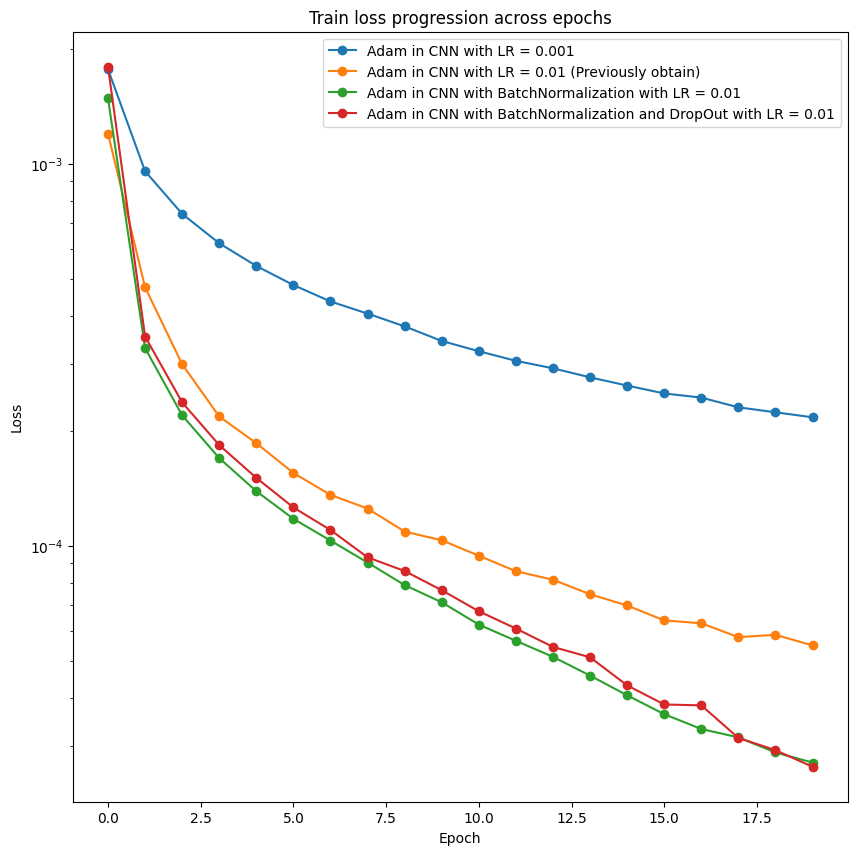

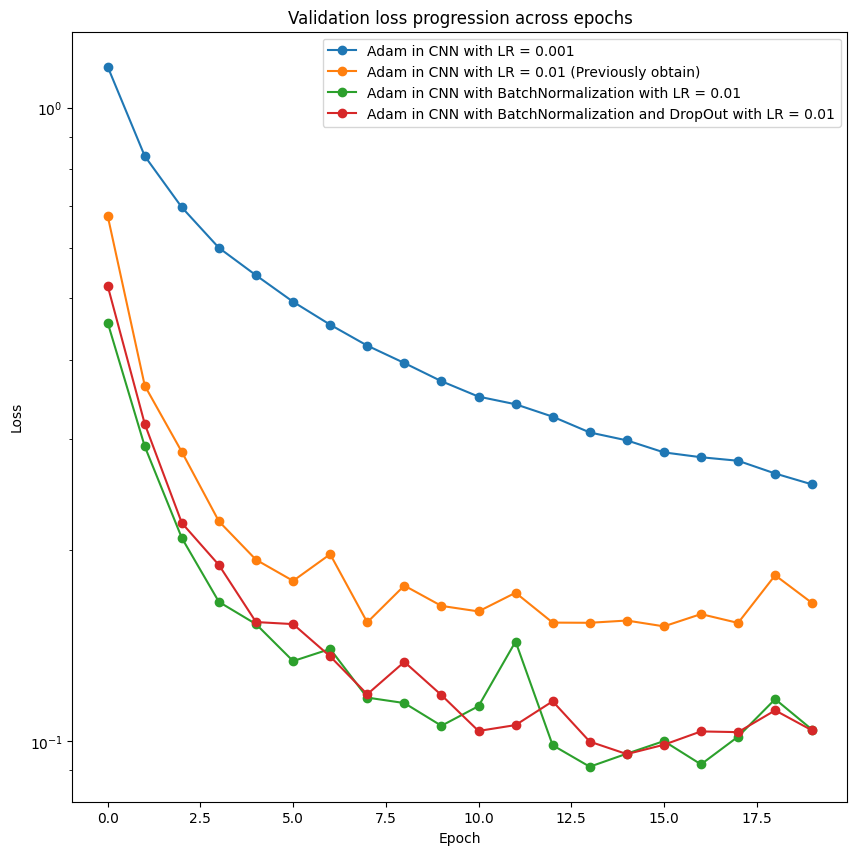

In [39]:
#Model with Adam Optimizer and Learning Rate : 0.001 so try to change the learning rate
modelAdam_001_CNN_lr = CNN()
optimizerAdam_001_CNN_lr = optim.Adam(modelAdam_001_CNN_lr.parameters(), lr=0.001)
print('Adam in CNN with LR = 0.001')
train_losses_adam001_CNN_lr, valid_losses_adam001_CNN_lr, valid_accs_adam001_CNN_lr = fit(modelAdam_001_CNN_lr, train_dataloader, optimizerAdam_001_CNN_lr, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelAdam_001_CNN_lr, test_dataloader, device = DEVICE)


#Model with Adam Optimizer and Learning Rate : 0.01 and try to had batch normalization
modelAdam_001_CNN_BN = CNNwithBN()
optimizerAdam_001_CNN_BN = optim.Adam(modelAdam_001_CNN_BN.parameters(), lr=0.01)
print('Adam in CNN with BatchNormalization with LR = 0.01')
train_losses_adam001_CNN_BN, valid_losses_adam001_CNN_BN, valid_accs_adam001_CNN_BN = fit(modelAdam_001_CNN_BN, train_dataloader, optimizerAdam_001_CNN_BN, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelAdam_001_CNN_BN, test_dataloader, device = DEVICE)


modelAdam_001_CNN_BN_DropOut = CNNwithBNandDropOut()
optimizerAdam_001_CNN_BN_DropOut = optim.Adam(modelAdam_001_CNN_BN_DropOut.parameters(), lr=0.01)
print('Adam in CNN with BatchNormalization and DropOut with LR = 0.01')
train_losses_adam001_CNN_BN_DropOut, valid_losses_adam001_CNN_BN_DropOut, valid_accs_adam001_CNN_BN_DropOut = fit(modelAdam_001_CNN_BN_DropOut, train_dataloader, optimizerAdam_001_CNN_BN_DropOut, EPOCHS, device = DEVICE,valid_dataloader=validation_dataloader)
predict(modelAdam_001_CNN_BN_DropOut, test_dataloader, device = DEVICE)

plt.figure(figsize=(10, 10))
plt.plot(train_losses_adam001_CNN_lr, label = "Adam in CNN with LR = 0.001", marker = 'o')
plt.plot(train_losses_adam001_CNN, label = "Adam in CNN with LR = 0.01 (Previously obtain)", marker = 'o')
plt.plot(train_losses_adam001_CNN_BN, label = "Adam in CNN with BatchNormalization with LR = 0.01", marker = 'o')
plt.plot(train_losses_adam001_CNN_BN_DropOut, label = "Adam in CNN with BatchNormalization and DropOut with LR = 0.01", marker = 'o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Train loss progression across epochs")
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(valid_losses_adam001_CNN_lr, label = "Adam in CNN with LR = 0.001", marker = 'o')
plt.plot(valid_losses_adam001_CNN, label = "Adam in CNN with LR = 0.01 (Previously obtain)", marker = 'o')
plt.plot(valid_losses_adam001_CNN_BN, label = "Adam in CNN with BatchNormalization with LR = 0.01", marker = 'o')
plt.plot(valid_losses_adam001_CNN_BN_DropOut, label = "Adam in CNN with BatchNormalization and DropOut with LR = 0.01", marker = 'o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Validation loss progression across epochs")
plt.show()



In [40]:
print('What was obtained before : ')
print('Test Accuracy with Adam with LR = 0.01')
predict(modelAdam_001_CNN, test_dataloader, device = DEVICE)
print('----------------------------------------------------------------------')
print('With our new try : ')
print('Test Accuracy with Adam with LR = 0.001')
predict(modelAdam_001_CNN_lr, test_dataloader, device = DEVICE)
print('----------------------------------------------------------------------')
print('Test Accuracy with Adam with BatchNormalization with LR = 0.01')
predict(modelAdam_001_CNN_BN, test_dataloader, device = DEVICE)
print('----------------------------------------------------------------------')
print('Test Accuracy with Adam with BatchNormalization and DropOut with LR = 0.01')
predict(modelAdam_001_CNN_BN_DropOut, test_dataloader, device = DEVICE)



What was obtained before : 
Test Accuracy with Adam with LR = 0.01
Test set: Avg. loss: 0.4176, Accuracy: 9030/10000 (90%)
----------------------------------------------------------------------
With our new try : 
Test Accuracy with Adam with LR = 0.001
Test set: Avg. loss: 0.5245, Accuracy: 8443/10000 (84%)
----------------------------------------------------------------------
Test Accuracy with Adam with BatchNormalization with LR = 0.01
Test set: Avg. loss: 0.3352, Accuracy: 9184/10000 (92%)
----------------------------------------------------------------------
Test Accuracy with Adam with BatchNormalization and DropOut with LR = 0.01
Test set: Avg. loss: 0.3158, Accuracy: 9251/10000 (93%)


(0.3157533630371094, tensor(92.5100, device='cuda:0'))

So seeing the graph with Losses (Validation and Test) we clearly see that with a Batch Normalization we obtain a really higher performance (93% vs 90%). But if we change the learning rate we don't obtain a better value. Adding a DropOut don't change a lot our result with a batch normalization, but we can clearly affirm that we found a better Neural Network adding a Batch Normalization!

In [41]:
integer_values_3 = [tensor.item() for tensor in accuracies]
df.loc[len(df)] = ['Adam', '0.001', 'CNN', 'KMNIST', integer_values_3[-3]]
df.loc[len(df)] = ['Adam', '0.01', 'CNN with BN', 'KMNIST', integer_values_3[-2]]
df.loc[len(df)] = ['Adam', '0.01', 'CNN with BN and DO', 'KMNIST', integer_values_3[-1]]
df['Accuracies'] = df['Accuracies'].apply(lambda x: np.round(x,2))
df

,Models,Learning Rate,Neural Net,Dataset,Accuracies
0,SGD,0.01,MLP,KMNIST,53.46
1,SGD with Momentum,0.01,MLP,KMNIST,78.63
2,Adam,0.01,MLP,KMNIST,87.42
3,Adam,1,MLP,KMNIST,10.00
4,SGD,0.01,CNN,KMNIST,39.66
5,SGD with Momentum,0.01,CNN,KMNIST,82.95
6,Adam,0.01,CNN,KMNIST,90.30
7,Adam,1,CNN,KMNIST,10.00
8,SGD with Momentum,0.01,MLP,PermutedKMNIST,78.41
9,SGD with Momentums,0.01,CNN,PermutedKMNIST,56.22


Here there is a small Summary of all this result and seeing that the best final model that we obtain is the model of CNN with Batch Normalization and Drop Out and a Learning Rate of 0.01. And we increase a lot our accuracy till 93% with CNN and Batch Normalization. So we succesfully fullfill what it was ask to us in the bonus point to increase the performance of our model.